In [ ]:
!pip install itables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.3 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

import itables
from itables import show

In [ ]:
# Загрузка данных
path = 'data_eda.csv'
data = pd.read_csv(path).drop(columns=['Unnamed: 0', 'IC50, mM','CC50, mM'], axis=1)
data.head(3)

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_thiazole,fr_thiophene,fr_unbrch_alkane,SI
0,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,0.038844,-0.293526,0.642857,14.822266,...,0,0,0,0,0,0,0,0,3,28.125
1,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,0.012887,-0.313407,0.607143,14.975110,...,0,0,0,0,0,0,0,0,3,7.000
2,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,0.094802,-0.325573,0.562500,15.353938,...,0,0,0,0,2,0,0,0,3,0.720


In [ ]:
show(data.corr()['SI'])

Loading ITables v2.4.2 from the internet... (need help?)


#  Отбор признаков

In [ ]:
def correlation_feature_selections(df, target_col, threshold=0.05):
    # Оставляем только числовые признаки
    df_numeric = df.select_dtypes(include=[float, int])

    # Вычисляем корреляции с целевой переменной
    correlations = df_numeric.corr()[target_col].abs().sort_values(ascending=False)

    # Отбираем признаки с корреляцией выше порога
    selected_features = correlations[correlations > threshold].index.tolist()
    selected_features.remove(target_col)  # удаляем целевую переменную из признаков

    print(f"Выбранные признаки ({len(selected_features)}): {selected_features}")
    return selected_features

In [ ]:
selected_features_by_corr = correlation_feature_selections(data, target_col='SI')

Выбранные признаки (19): ['BalabanJ', 'fr_NH2', 'fr_Al_COO', 'VSA_EState4', 'FpDensityMorgan1', 'NumAliphaticHeterocycles', 'MolLogP', 'EState_VSA2', 'fr_bicyclic', 'SMR_VSA5', 'fr_NH1', 'NumAromaticHeterocycles', 'NumSaturatedHeterocycles', 'SlogP_VSA3', 'MinAbsEStateIndex', 'MinPartialCharge', 'SlogP_VSA8', 'fr_amide', 'PEOE_VSA10']


In [ ]:
def random_forest_feature_selection(df, target_col, n_top=20):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Разделение на трейн/тест
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

    # Обучаем модель
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Получаем важность признаков
    importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

    # Выводим топ-N самых важных
    top_features = importance.head(n_top).index.tolist()
    print(f"Топ-{n_top} важных признаков:\n", top_features)

    # График важности
    importance.nlargest(n_top).plot(kind='barh', figsize=(10, 8))
    plt.title("Feature Importance")
    plt.show()

    return top_features

Топ-10 важных признаков:
 ['BalabanJ', 'MinAbsEStateIndex', 'VSA_EState9', 'MaxAbsEStateIndex', 'PEOE_VSA7', 'VSA_EState7', 'VSA_EState4', 'BCUT2D_MWHI', 'SMR_VSA5', 'MaxPartialCharge']


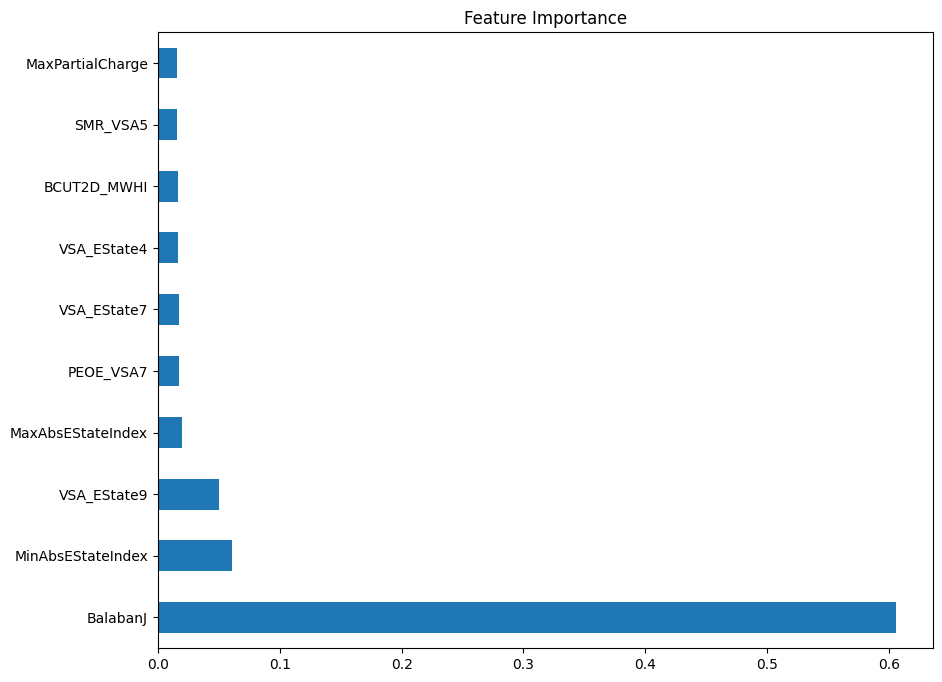

In [ ]:
selected_features_by_rand_for = random_forest_feature_selection(data, target_col='SI', n_top=10)

In [ ]:
def lasso_feature_selection(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Стандартизируем данные
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Подбор оптимального alpha и обучение Lasso
    model = LassoCV(cv=5, random_state=42, max_iter=10000)
    model.fit(X_scaled, y)

    # Определяем, какие признаки не занулены
    coef = pd.Series(model.coef_, index=X.columns)
    selected_features = coef[coef != 0].index.tolist()

    print(f"Коэффициенты:\n{coef.sort_values(ascending=False)}")
    print(f"Оставлено признаков: {len(selected_features)}")
    print("Оставленные признаки:", selected_features)

    return selected_features

In [ ]:
selected_features_by_lasso = lasso_feature_selection(data, target_col='SI')

Коэффициенты:
BalabanJ       106.115422
SMR_VSA5        66.734020
fr_NH2          62.298789
fr_Al_COO       53.888409
VSA_EState4     48.984078
                  ...    
fr_methoxy     -14.933116
fr_bicyclic    -15.876431
PEOE_VSA2      -16.693194
fr_ArN         -36.186055
fr_priamide    -48.150953
Length: 94, dtype: float64
Оставлено признаков: 32
Оставленные признаки: ['MinEStateIndex', 'qed', 'MaxPartialCharge', 'MinPartialCharge', 'FpDensityMorgan1', 'BCUT2D_MWLOW', 'BalabanJ', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA5', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA4', 'SMR_VSA5', 'SlogP_VSA2', 'EState_VSA2', 'EState_VSA9', 'VSA_EState4', 'VSA_EState9', 'NumAromaticHeterocycles', 'fr_Al_COO', 'fr_ArN', 'fr_Imine', 'fr_NH1', 'fr_NH2', 'fr_Ndealkylation2', 'fr_allylic_oxid', 'fr_aryl_methyl', 'fr_bicyclic', 'fr_methoxy', 'fr_nitro', 'fr_priamide']


# Отбор моделей, гиперпараметров и предсказания по лучшим параметрам

In [ ]:
def get_models():
  models = {
      "Linear Regression": {
          "model": LinearRegression(),
          "params": {}
      },
      "Random Forest": {
          "model": RandomForestRegressor(random_state=42),
          "params": {
              'n_estimators': [20, 50, 100],
              'max_depth': [None, 5, 10, 20],
              'min_samples_split': [2, 3, 5, 10]
          }
      },
      "Gradient Boosting": {
          "model": GradientBoostingRegressor(random_state=42),
          "params": {
              'n_estimators': [50, 100],
              'learning_rate': [0.01, 0.1],
              'max_depth': [3, 5]
          }
      },
      "XGBoost": {
          "model": XGBRegressor(random_state=42, eval_metric='logloss'),
          "params": {
              'n_estimators': [50, 100],
              'learning_rate': [0.01, 0.1],
              'max_depth': [3, 5]
          }
      },
      'CatBoost':{
          "model":  CatBoostRegressor(random_seed=42, verbose=0),
          "params": {
              'iterations': [100, 300],
              'learning_rate': [0.01, 0.05, 0.1],
              'depth': [4, 8],
              'l2_leaf_reg': [1, 5, 7]
          }
      }
  }

  return models

In [ ]:
def get_regression(X_train, y_train, X_test, y_test):
  models = get_models()
  results = []
  for model_name, config in models.items():
      print(f"\nОбучение модели: {model_name}")

      if not config['params']:  # пропускаем пустые параметры (например, у LinearRegression)
          model = config['model']
          model.fit(X_train, y_train)
          best_params = {}
      else:
          grid = GridSearchCV(config['model'], config['params'], cv=5, scoring='r2', n_jobs=-1)
          grid.fit(X_train, y_train)
          model = grid.best_estimator_
          best_params = grid.best_params_

      # Предсказание
      y_pred = model.predict(X_test)

      # Метрики
      mae = mean_absolute_error(y_test, y_pred)
      rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      r2 = r2_score(y_test, y_pred)

      results.append({
          "Model": model_name,
          "Best Params": best_params,
          "MAE": mae,
          "RMSE": rmse,
          "R²": r2
      })

      print(f"Лучшие параметры: {best_params}")
      print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

  return results

# Результаты

In [ ]:
X = data.drop('SI', axis=1)
y = data['SI']

# Разделение на трейн/тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

res1 = get_regression(X_train, y_train, X_test, y_test)


Обучение модели: Linear Regression
Лучшие параметры: {}
MAE: 259.0015, RMSE: 426.4853, R²: -8.1743

Обучение модели: Random Forest
Лучшие параметры: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}
MAE: 113.0389, RMSE: 417.7727, R²: -7.8033

Обучение модели: Gradient Boosting
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
MAE: 87.2736, RMSE: 208.1407, R²: -1.1851

Обучение модели: XGBoost
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
MAE: 66.6657, RMSE: 142.9167, R²: -0.0302

Обучение модели: CatBoost
Лучшие параметры: {'depth': 8, 'iterations': 100, 'l2_leaf_reg': 7, 'learning_rate': 0.01}
MAE: 82.5009, RMSE: 186.0527, R²: -0.7460


In [ ]:
X = data[selected_features_by_corr]
y = np.log(data['SI'])

# Разделение на трейн/тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

res4 = get_regression(X_train, y_train, X_test, y_test)


Обучение модели: Linear Regression
Лучшие параметры: {}
MAE: 1.3842, RMSE: 1.7192, R²: -0.0077

Обучение модели: Random Forest
Лучшие параметры: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
MAE: 1.2029, RMSE: 1.5617, R²: 0.1685

Обучение модели: Gradient Boosting
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
MAE: 1.2224, RMSE: 1.5811, R²: 0.1477

Обучение модели: XGBoost
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
MAE: 1.2639, RMSE: 1.5988, R²: 0.1285

Обучение модели: CatBoost
Лучшие параметры: {'depth': 8, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
MAE: 1.1835, RMSE: 1.5222, R²: 0.2101


In [ ]:
X = data[selected_features_by_lasso]
y = np.log(data['SI'])

# Разделение на трейн/тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

res3 = get_regression(X_train, y_train, X_test, y_test)


Обучение модели: Linear Regression
Лучшие параметры: {}
MAE: 1.2668, RMSE: 1.6250, R²: 0.0997

Обучение модели: Random Forest
Лучшие параметры: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
MAE: 1.2072, RMSE: 1.5777, R²: 0.1514

Обучение модели: Gradient Boosting
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
MAE: 1.2518, RMSE: 1.6166, R²: 0.1090

Обучение модели: XGBoost
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
MAE: 1.2151, RMSE: 1.6232, R²: 0.1017

Обучение модели: CatBoost
Лучшие параметры: {'depth': 8, 'iterations': 100, 'l2_leaf_reg': 7, 'learning_rate': 0.1}
MAE: 1.1730, RMSE: 1.5141, R²: 0.2185


In [ ]:
X = data[selected_features_by_rand_for]
y = np.log(data['SI'])

# Разделение на трейн/тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

res2 = get_regression(X_train, y_train, X_test, y_test)


Обучение модели: Linear Regression
Лучшие параметры: {}
MAE: 1.3533, RMSE: 1.7007, R²: 0.0139

Обучение модели: Random Forest
Лучшие параметры: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}
MAE: 1.2950, RMSE: 1.6374, R²: 0.0859

Обучение модели: Gradient Boosting
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
MAE: 1.3359, RMSE: 1.7309, R²: -0.0215

Обучение модели: XGBoost
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
MAE: 1.2761, RMSE: 1.6395, R²: 0.0836

Обучение модели: CatBoost
Лучшие параметры: {'depth': 8, 'iterations': 300, 'l2_leaf_reg': 7, 'learning_rate': 0.05}
MAE: 1.2463, RMSE: 1.5936, R²: 0.1342


Отбор происходил по метрике R^2 как самой показательной. Самый лучший показатель был у CatBoost без отбора признаков с признаками  {'depth': 8, 'iterations': 300, 'l2_leaf_reg': 7, 'learning_rate': 0.05} и метриками: MAE: 1.1745, RMSE: 1.5097, R²: 0.2230